# ProductNet: Categorize products using image(s) and text descriptors
## Jen Sheng Wong and Kartik Nanda (Cohort 14)
Based on following paper: https://arxiv.org/pdf/1904.09037.pdf

## Problem Statement:
Relates primarily to products on retail/marketplace sites such as Amazon. The problem deals with 3 main aspects:
* Trying to categorize products. Number of categories ~5700 (using the Google taxonomy: https://github.com/fellowship/platform-demos3/blob/master/ProductNet/taxonomy-with-ids.en-US.xls)
* Product has images (1 or more)
* Product has text - title, description, keywords

Possible end-problems to solve: 
a) Find the category, given product images and user provided text description. 
b) Find mis-categorized products

## Dataset: 
Products for sale on Amazon; product details from 1996 through 2014, by Prof. McAuley at UCSD
Citations:
* R. He, J. McAuley. Modeling the visual evolution of fashion trends with one-class collaborative filtering. WWW, 2016
* J. McAuley, C. Targett, J. Shi, A. van den Hengel. Image-based recommendations on styles and substitutes. SIGIR, 2015

## Dataset Storage:
* Used Google storage bucket located at gs://platform-ai-research/datasets/ProductNet/
* Also used Jen Sheng's Google Drive for intermediate files, images etc

## Approaches
### Approach in Paper
The paper assumes that the dataset is unlabeled, and uses the product images in conjunction with the text descriptors (title, keywords, description) to generate a label. It uses an iterative process that includes a master model and a local model. The master model predicts the categories from the images and text. The local model is used to find similar products (possibly using the activations from the master model). These products are then manually labeled. Once a few labels are generated, the set is again fed to the master model, and the process repeats. 

The paper reports having labeled 178000 products across 3900 categories (approx 40 to 60 products per category/label). The prediction accuracy of the master model on the labeled data is 94.7%

### Our Challenges, and Approaches
* Do not have access to the labeled dataset the authors used. So we cannot reproduce the accuracy they have reported on their dataset.
* The first challenge was to create a dataset. Downloaded one of products on Amazon (see citations above) from UCSD. The dataset has product images, title, description,  and categories. 

#### First Approach: use categories column as labels
Our first approach was to use the categories as the label, however, soon realised that it isn't. For one there are roughly 90,000 unique entries. And second, a more detailed examination reveals these are actually key words. Accuracy on a narrower dataset (142 classes) was ~3% 

#### Second Appraoch: similar to the paper's authors' approach
Like the authors, our data is also unlabeled. We have images, and text descriptors. One possible approach is to reproduce the paper's work, namely create a labeled dataset. We could build a text model + image model as the master, and use Platform.ai for labeling and to find similar products (the local model). Used iteratively, this could be used to label enough products to build a robust model. 

Issues with this approach: 
The main issue is Platform.ai does not currently support text.

#### Third Appraoch: generate labels from categories using text mapping
Generate labels from only the text descriptors. We used the categories (key words) entries to generate a label for the product. The labels are from the Google taxonomy (same as used in the paper). The file is stored in the GS bucket. 

We used the Universal Sentence Encoder (USE) to map the category description to a label (minimal distance between the encodings). This was done for the entire 5.5 million dataset. 

For this try, we did not map to the leaf node (~5700 leaf nodes in the google taxo label doc). Instead, mapped to level 2 (shallower) - this provides fewer classes but inconsistent depth (so its not perfect). We got 142 labels. 

#### Fourth Approach: generate labels in Platform.ai
We took a smaller set of 1440 images from 10 categories (labels). The labels were arbitrarily picked from the 20k dataset (142 categories), based on the assigned category/ labels. This is not a clean dataset because there are many mis-labled images in the 20k dataset 

 


In [1]:
!pip install fastai
!pip install -U pyarrow

import numpy as np
import pandas as pd
import seaborn as sns

import requests
import ast
import os
import gc
import matplotlib.pyplot as plt

from fastai.vision import *
from fastai.metrics import error_rate, accuracy

     |████████████████████████████████| 48.5MB 65.3MB/s 


## Setup the Google Storage Bucket for images, df datasets etc
Download relevant files from here into the CoLab working space

In [2]:
# Will need to login to access the bucket. The following lines of code do just that
from google.colab import auth
auth.authenticate_user()

# List out all the files in the directory (Make sure that we are logged in)
gs_path = 'platform-ai-research/datasets/ProductNet/'
!gsutil ls gs://{gs_path}

gs://platform-ai-research/datasets/ProductNet/ProductNet_small_prediction_2.csv
gs://platform-ai-research/datasets/ProductNet/crawl-300d-2M.vec
gs://platform-ai-research/datasets/ProductNet/df2_20000
gs://platform-ai-research/datasets/ProductNet/df2_clean_THRESHOLD_5_4
gs://platform-ai-research/datasets/ProductNet/df2_clean_THRESHOLD_7
gs://platform-ai-research/datasets/ProductNet/df2_clean_THRESHOLD_7_2
gs://platform-ai-research/datasets/ProductNet/df2_clean_THRESHOLD_7_3
gs://platform-ai-research/datasets/ProductNet/df_new_label
gs://platform-ai-research/datasets/ProductNet/images_folder_0523.zip
gs://platform-ai-research/datasets/ProductNet/labels_5m
gs://platform-ai-research/datasets/ProductNet/metadata.feather
gs://platform-ai-research/datasets/ProductNet/metadata_clean_0513
gs://platform-ai-research/datasets/ProductNet/taxonomy-with-ids.en-US.xls
gs://platform-ai-research/datasets/ProductNet/urls_20000
gs://platform-ai-research/datasets/ProductNet//
gs://platform-ai-research/data

In [3]:
# Pull from GS bucket
gs_path = 'platform-ai-research/datasets/ProductNet/'

# This file contains all ~5.5 million labels and asin. It does not contain the urls, 
# so need to merge with metadata_clean_0513 to get the urls
# Reason for doin this way: creating the labels for the 5.5m data points was a time and
# memory intensive process. We did not want to keep the unnecessary data like urls in the files
file_name = 'labels_5m'

remote_file = gs_path + file_name
!gsutil cp gs://{remote_file} {file_name} 

Copying gs://platform-ai-research/datasets/ProductNet/labels_5m...
/ [1 files][202.9 MiB/202.9 MiB]                                                
Operation completed over 1 objects/202.9 MiB.                                    


In [0]:
# Next step is to download the images
# Create the images folder
if (not os.path.exists('./images/')):
    !mkdir 'images'

# There are nearly 30K images (as of May 21st, 2019) in the GS images folder
# It can take a while to download. In some cases it is easier to download only the 
# relevant ones from the web, which is done later

#!gsutil -m cp gs://{gs_path}images/*.jpg ./images

## Creating the working dataset 
Create a smaller datatset that contins only 10 classes of choice

In [8]:
# Read in the 5.5m data
df = pd.read_feather('labels_5m')
print('Number of Categories: ', df['label'].nunique())
df.head()

Number of Categories:  157


,asin,label
0,0000037214,Clothing Accessories
1,0000032069,Clothing
2,0000031909,Athletics
3,0000032034,Clothing
4,0000031852,Athletics


In [9]:
# generate a count of the unique labels, and remove categories (labels) with less that
# some number of datapoints
val_cnt = pd.DataFrame(df['label'].value_counts(sort=True)).reset_index()
print(val_cnt.head())

REMOVE_N_LESS_THAN = 125
remove = val_cnt[val_cnt['label'] < REMOVE_N_LESS_THAN]['index'].tolist()
remove

                         index    label
0         Clothing Accessories  1126894
1      Electronics Accessories   425398
2  Vehicle Parts & Accessories   278705
3    Handbags, Wallets & Cases   259496
4                     Clothing   236994


['Small Engines',
 'Live Animals',
 'Finance & Insurance',
 'Mining & Quarrying',
 'Erotic',
 'Shipping Supplies',
 'Heavy Machinery',
 'Magazines & Newspapers',
 'Presentation Supplies',
 'Fanny Packs',
 'Religious Items',
 'Plants',
 'Ottomans',
 'Briefcases',
 'Vehicles']

In [10]:
# Remove categories where number of data is too few
df = df[~df['label'].isin(remove)]
print('Number of categories left: ', df['label'].nunique())

Number of categories left:  142


In [11]:
# Extract data from preselected categories of interest
# This is done to make the problem we are trying to solve tractable
select = ['Shoes', 'Clothing', 'Personal Care',
          'Backpacks', 'Vehicle Parts & Accessories',
          'Toys', 'Sofas', 'Puzzles',
          'Jewelry', 'Lawn & Garden']

df = df[df['label'].isin(select)]
df.head()

,asin,label
1,0000032069,Clothing
3,0000032034,Clothing
5,0000032050,Clothing
6,0000031887,Clothing
7,0000191639,Puzzles


In [12]:
df.shape

(725009, 2)

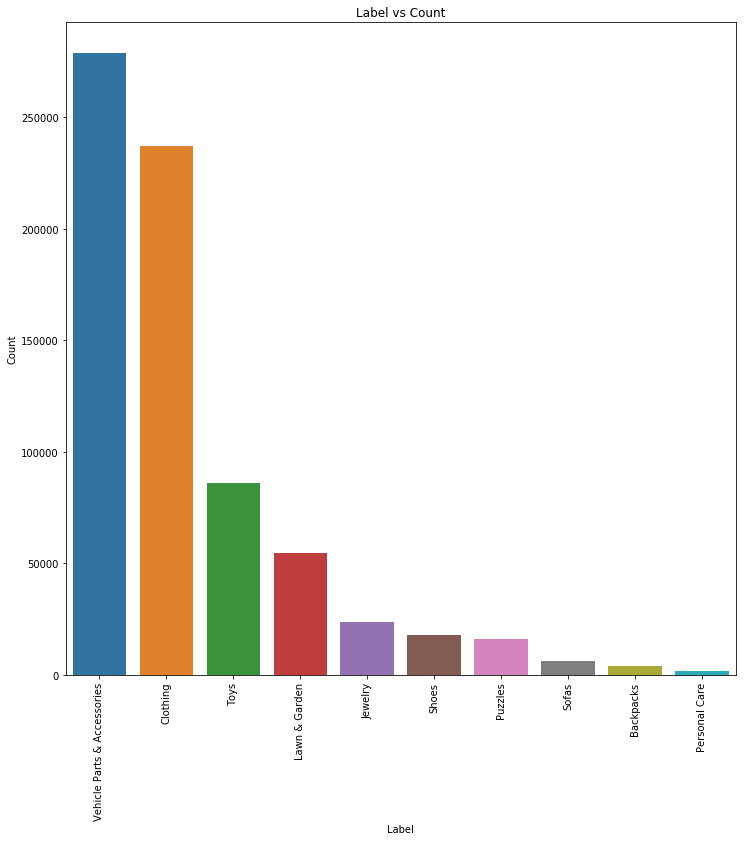

In [14]:
# plot the categories, and data count
val_cnt = df['label'].value_counts(sort=True)

plt.figure(figsize=(12,12))
sns.barplot(val_cnt.index, 
            val_cnt.values)

plt.xlabel('Label')
plt.xticks(range(len(val_cnt)), val_cnt.index, rotation='vertical')
plt.ylabel('Count')
plt.title('Label vs Count')
plt.show()

### Randomly extract a sample from the dataset
Since the dataset is fairly large, extract a smaller set to work with. Sub-sampling allows us to randomly select from the available data. We assign weights to the data to get roughly the same number of samples in each category

In [17]:
# Calculate the weights for subsampling
val_cnt = pd.DataFrame(val_cnt).reset_index()
val_cnt = val_cnt.rename(columns={'index': 'label', 'label': 'count'})
val_cnt['weight'] = 1/val_cnt['count']

val_cnt.head()

,label,count,weight
0,Vehicle Parts & Accessories,278705,0.000004
1,Clothing,236994,0.000004
2,Toys,85906,0.000012
3,Lawn & Garden,54706,0.000018
4,Jewelry,23642,0.000042


In [20]:
# assign weight to each entry in df
weightage = dict(zip(val_cnt['label'], val_cnt['weight']))

df['weight'] = df['label'].map(weightage)

print('Sum of all weights (should equal the number of categories in data) =', sum(df['weight']))
df.head()

Sum of all weights (should equal the number of categories in data) = 10.000000000025194


,asin,label,weight
1,0000032069,Clothing,0.000004
3,0000032034,Clothing,0.000004
5,0000032050,Clothing,0.000004
6,0000031887,Clothing,0.000004
7,0000191639,Puzzles,0.000062


In [21]:
# Sample the dataset
SAMPLE_SIZE = 5000
df2 = df.sample(n=SAMPLE_SIZE, weights='weight', random_state=42)
df2 = df2[['asin', 'label']].copy()
df2.head()

,asin,label
1980386,B003U4RZ6A,Toys
5251008,B00GP3I2SS,Backpacks
4065965,B009R7ZXB8,Toys
3281311,B0074CCCXK,Jewelry
866882,B0012LJITU,Sofas


In [23]:
print(df2.shape)
val_cnt = df2['label'].value_counts(sort=True)
val_cnt

(5000, 2)


Lawn & Garden                  594
Clothing                       544
Shoes                          526
Toys                           509
Vehicle Parts & Accessories    501
Jewelry                        500
Sofas                          497
Puzzles                        460
Backpacks                      439
Personal Care                  430
Name: label, dtype: int64

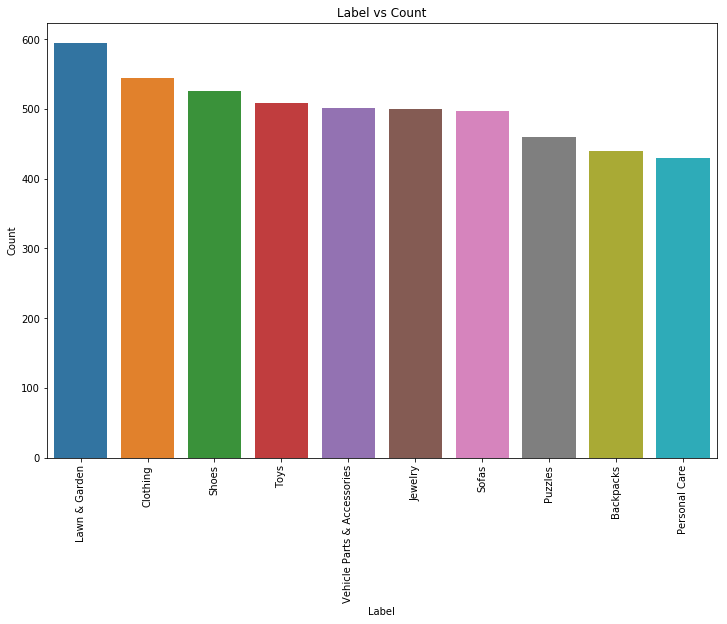

In [24]:
plt.figure(figsize=(12,8))
sns.barplot(val_cnt.index, 
            val_cnt.values)

plt.xlabel('Label')
plt.xticks(range(len(val_cnt)), val_cnt.index, rotation='vertical')
plt.ylabel('Count')
plt.title('Label vs Count')
plt.show()

## Get the images (either download from GS or the Web)
About 30k images are downloaded and stored in the images folder in the bucket, however, that is out of 5.5million possible. 
It is also sometimes quicker to download the images directly from the web url

In [25]:
# First get the original metadata file which contains the images' URLs
file_name = 'metadata_clean_0513'

if (not os.path.isfile(file_name)):    # chk in the local first
    try:
        remote_file = gs_path + file_name  # copy from GS
        !gsutil cp gs://{remote_file} .
    except Exception as e:
        print('File not found')


Copying gs://platform-ai-research/datasets/ProductNet/metadata_clean_0513...
\ [1 files][  3.1 GiB/  3.1 GiB]   87.5 MiB/s                                   
Operation completed over 1 objects/3.1 GiB.                                      


In [0]:
urls_ = pd.read_feather(file_name)

In [31]:
urls_.drop(columns=['index', 'categories', 'description', 'title', 'label'], inplace=True)
urls_.head()

,asin,imUrl
0,0000037214,http://ecx.images-amazon.com/images/I/31mCncNu...
1,0000032069,http://ecx.images-amazon.com/images/I/51EzU6qu...
2,0000031909,http://ecx.images-amazon.com/images/I/41xBoP0F...
3,0000032034,http://ecx.images-amazon.com/images/I/21GNUNIa...
4,0000031852,http://ecx.images-amazon.com/images/I/51fAmVkT...


In [0]:
# Merge df and urls_
url_df = pd.merge(df2, urls_,
                 left_on='asin', right_on='asin',
                 how='inner')

In [93]:
print(len(url_df))
url_df.head()

5000


,asin,label,imUrl
0,B003U4RZ6A,Toys,http://ecx.images-amazon.com/images/I/51ylHl8G...
1,B00GP3I2SS,Backpacks,http://ecx.images-amazon.com/images/I/41K-x0Nq...
2,B009R7ZXB8,Toys,http://ecx.images-amazon.com/images/I/51Bn-uMw...
3,B0074CCCXK,Jewelry,http://ecx.images-amazon.com/images/I/41butp9%...
4,B0012LJITU,Sofas,http://ecx.images-amazon.com/images/I/61NO8Sq3...


In [94]:
# Fix a few label names so they have no spaces, & etc because these will be used as folder names
def relabel(s):
    s = '_'.join(s.split(' '))
    return s.replace('_&_', '_')
  
print('old labels', url_df.label.unique())

url_df.label = url_df.label.apply(relabel)

print('new labels', url_df.label.unique())

old labels ['Toys' 'Backpacks' 'Jewelry' 'Sofas' 'Puzzles' 'Vehicle Parts & Accessories' 'Personal Care' 'Lawn & Garden' 'Shoes'
 'Clothing']
new labels ['Toys' 'Backpacks' 'Jewelry' 'Sofas' 'Puzzles' 'Vehicle_Parts_Accessories' 'Personal_Care' 'Lawn_Garden' 'Shoes'
 'Clothing']


In [0]:
imUrls = url_df.imUrl.tolist()
labels = url_df.label.tolist()
asins  = url_df.asin.tolist()

In [96]:
url_df.label.unique()

array(['Toys', 'Backpacks', 'Jewelry', 'Sofas', 'Puzzles', 'Vehicle_Parts_Accessories', 'Personal_Care', 'Lawn_Garden',
       'Shoes', 'Clothing'], dtype=object)

In [0]:
# Create folders for the images
# Create the images folder
if (not os.path.exists('./images/')):
    !mkdir 'images'

# create the sub-folders
for fn in url_df.label.unique():
    fn_ = './images/'+fn
    if (not os.path.exists(fn_)):
        print('creating ',fn_)
        !mkdir {fn_}

In [0]:
from tqdm import tqdm
from PIL import Image

#%%time
for url_label_id in (zip(imUrls, labels, asins)):
    url = url_label_id[0] # url of image
    label = url_label_id[1].split(' ')[0] # label, if multiple words, use only first
    asin = url_label_id[2] # asin of image
    
    filename = './images/' + label + '/' + asin + '.jpg'    
    
#     print(filename)  
#     break
  
    # also check if file exists. If it does, do not reload it!
    if (not os.path.isfile(filename)):
        try:
            r = requests.get(url, allow_redirects=True)
            open(filename, 'wb').write(r.content)
            
        except Exception as e:
            url_df = url_df[url_df.asin != asin]           # if missing, remove from dataset
            print('Missing')
            with open("./missing_select_df.txt", "a") as f:
                f.write(asin+'\n')   

Missing
Missing


In [0]:
!rm missing_select_df.txt

In [18]:
from tqdm import tqdm
from PIL import Image

for url_id in tqdm(zip(imUrls, asins)):
    url = url_id[0] # url of image
    asin = url_id[1] # asin of image
    filename = './images/' + asin + '.jpg'
    
    try:
        img = Image.open(filename)
    except Exception as e:
        df = df[df.asin != asin]           # if missing, remove from dataset
        with open("./missing_imgs.txt", "a") as f:
            f.write(asin+'\n')

785it [00:00, 8540.00it/s]
